In [1]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sb
from pandas import read_excel, DataFrame, melt
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import pandas as pd
# 기본참조
from sklearnex import patch_sklearn
# Gpu 사용 가능한지 참조
from daal4py.oneapi import sycl_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
!pip install konlpy
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 한국어 처리를 위한 라이브러리
from konlpy.tag import Okt
okt = Okt()

# Excel 파일 읽기
file_path = '프로그램.xlsx'
train_data = pd.read_excel(file_path)

# 한국어 텍스트 데이터 전처리
def preprocess_korean_text(text):
    # 형태소 분석을 통한 단어 추출
    words = okt.morphs(text, stem=True)

    return ' '.join(words)

# 'review' 컬럼의 이름이 한국어 데이터에 맞게 변경되었다고 가정
train_data['내용'] = train_data['내용'].apply(preprocess_korean_text)

# 전처리된 데이터 확인
print(train_data.head())


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: c:\Users\user\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


   Unnamed: 0      프로그램명    유형  \
0         NaN      직장인요가  생활체육   
1         NaN       밴드체조  생활체육   
2         NaN       탁구교실  생활체육   
3         NaN  스마트폰 사진편집  IT관련   
4         NaN   명상과 스트레칭  생활체육   

                                                  내용  강좌개설정보   구청  
0  바쁘다 일상 속 신체 벨런스 가 무너지다 직장인 을 위 한 몸 의 바르다 정렬 을 ...       1  관악구  
1  밴드 를 이용 하다 진행 하다 체조 , 강사 님 을 따르다 체조 로 밴드 에 가하다...       0  관악구  
2  직사각형 나무 탁자 에 네트 를 걸다 양 사이드 에 선수 들 이 서서 탁구 채 로 ...       0  관악구  
3  스마트폰 갤러리 에 있다 사진 으로 나 만의 사진 편집 하다 , 라인 카메라 시작 ...       1  관악구  
4  고요하다 눈 을 감고 차분하다 마음 으로 깊이 생각 하다 것 이다 . 명상 은 일체...       0  관악구  


Text(0, 0.5, 'word count')

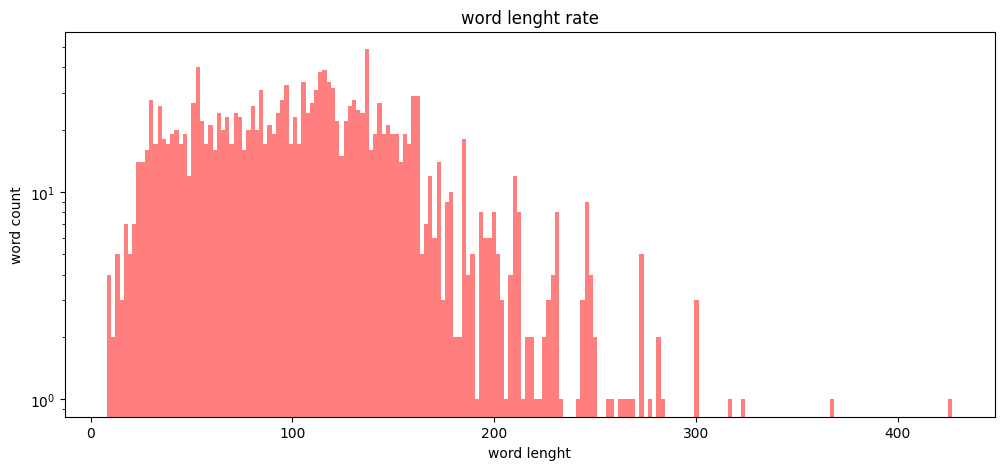

In [3]:
# 데이터 길이와 분포 시각화
train_length = train_data['내용'].apply(len)

plt.figure(figsize=(12,5))
plt.hist(train_length, bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log', nonpositive='clip')
plt.title('word lenght rate')
plt.xlabel('word lenght')
plt.ylabel('word count')

{'whiskers': [<matplotlib.lines.Line2D at 0x18fdc877f90>,
 'caps': [<matplotlib.lines.Line2D at 0x18fdc7e5f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x18fdb5114d0>],
 'medians': [<matplotlib.lines.Line2D at 0x18fdc89f550>],
 'fliers': [<matplotlib.lines.Line2D at 0x18fdc8b4610>],
 'means': [<matplotlib.lines.Line2D at 0x18fdc89fe10>]}

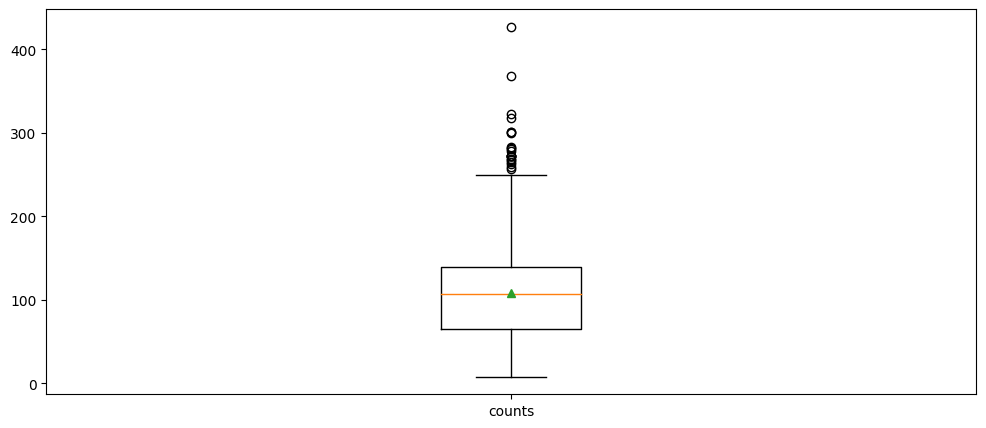

In [4]:
# 박스 플롯으로 데이터 길이 시각화
plt.figure(figsize=(12,5))
plt.boxplot(train_length, labels=['counts'], showmeans=True)

(-0.5, 799.5, 519.5, -0.5)

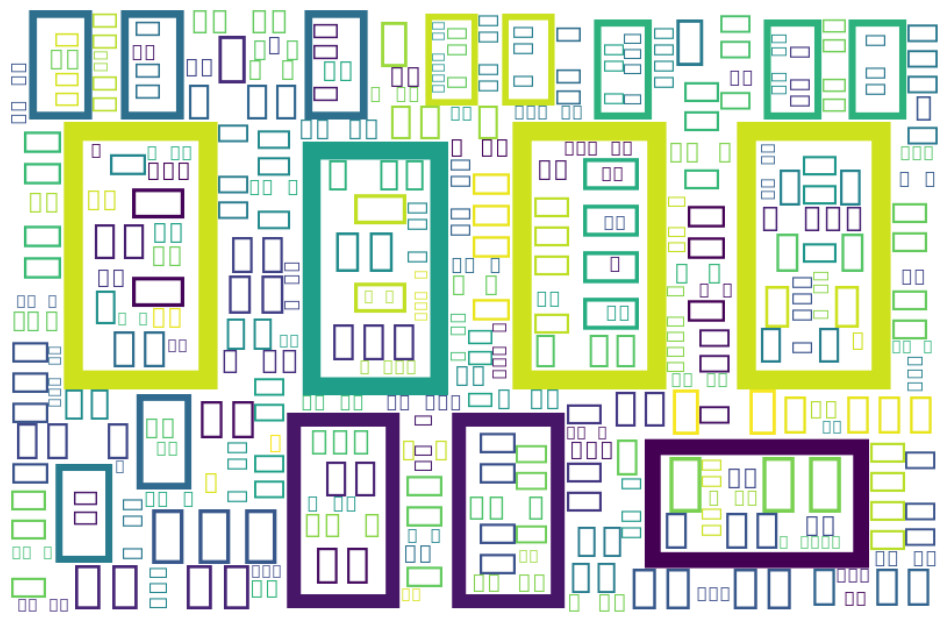

In [6]:
# 워드 클라우드 생성
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Malgun Gothic'
# 워드 클라우드 생성
cloud = WordCloud(width=800, height=520, background_color='white').generate(" ".join(train_data['내용']))
plt.figure(figsize=(12,8))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')

문장 최대 길이: 156
문장 최소 길이: 3
문장 평균 길이: 38.51
문장 길이 표준편차: 19.55
문장 중간 길이: 38.0
제1사분위 길이: 23.0
제3사분위 길이: 50.0


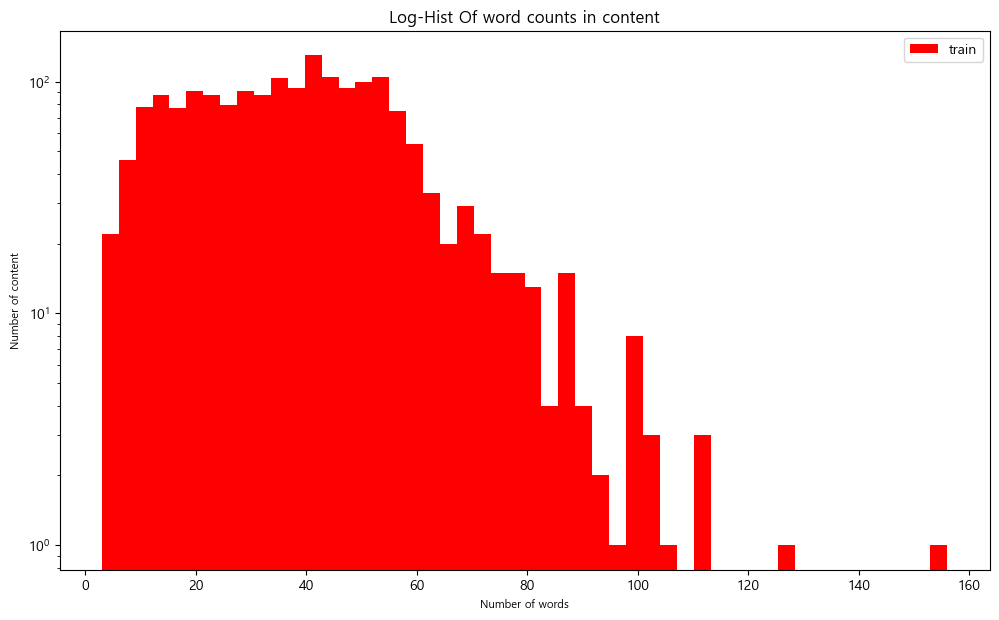

In [7]:
# 단어 개수 계산
train_word_counts = train_data['내용'].apply(lambda x : len(x.split(' ')))

# 단어 개수 히스토그램 시각화
plt.figure(figsize=(12,7))
plt.hist(train_word_counts, bins=50, facecolor='r', label='train')
plt.title('Log-Hist Of word counts in content', fontsize=12)
plt.yscale('log', nonpositive='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=8)
plt.ylabel('Number of content', fontsize=8)

# 단어 개수 통계 출력
print("문장 최대 길이: {}".format(np.max(train_word_counts)))
print("문장 최소 길이: {}".format(np.min(train_word_counts)))
print("문장 평균 길이: {:.2f}".format(np.mean(train_word_counts)))
print("문장 길이 표준편차: {:.2f}".format(np.std(train_word_counts)))
print("문장 중간 길이: {}".format(np.median(train_word_counts)))

# 사분위수 계산
print('제1사분위 길이: {}'.format(np.percentile(train_word_counts, 25)))
print('제3사분위 길이: {}'.format(np.percentile(train_word_counts, 75)))

In [8]:
import re
import pandas as pd
import numpy
import json
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
import re
import pandas as pd
import numpy as np
from konlpy.tag import Okt
import json
from bs4 import BeautifulSoup

# 파일 경로 설정
file_path = '프로그램.xlsx'

# Excel 파일 읽기
train_data = pd.read_excel(file_path)

# 첫 번째 리뷰 출력
print(train_data['내용'][0])

# 한국어 형태소 분석기 초기화
okt = Okt()

# 한국어 텍스트 데이터 전처리
def preprocess_korean_text(text):
    # HTML 태그 제거
    text = BeautifulSoup(text, "html.parser").get_text()

    # 한글만 남기고 나머지 제거
    text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)

    # 형태소 분석
    words = okt.morphs(text, stem=True)

    return ' '.join(words)

# 첫 번째 리뷰 전처리 후 출력
print(preprocess_korean_text(train_data['내용'][0]))

바쁜 일상 속 신체 벨런스가 무너진 직장인을 위한 몸의 바른 정렬을 중시, 정확한 자세와 호흡법, 연결 순서의 완성도, 행위 속의 명상추구, 보조 도구의 활동
바쁘다 일상 속 신체 벨런스 가 무너지다 직장인 을 위 한 몸 의 바르다 정렬 을 중시 정확하다 자세 와 호흡 법 연결 순서 의 완성 도 행위 속 의 명상 추구 보조 도구 의 활동


In [10]:
import nltk
nltk.download('stopwords')

# 한국어 리뷰 데이터 전처리 함수
def preprocessing(review, remove_stopwords=False):
    # 1. HTML 태그 제거
    review_text = BeautifulSoup(review, "html.parser").get_text()

    # 2. 한글과 공백을 제외한 모든 문자를 공백으로 바꾸기
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", review_text)

    # 3. 텍스트를 공백 단위로 나눠서 리스트로 만든다.
    words = review_text.split()

    if remove_stopwords:
        # 4. 불용어 제거, 한국어 불용어 불러오기
        stops = set(['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한', '및', '수', '등',
                     '하다', '대한', '있다', '과', '으로', '에 대한', '에 대해', '을 통한', '등을', '그', '즉',])
        # 불용어가 아닌 단어로 이뤄진 새로운 리스트 생성
        words = [w for w in words if not w in stops]

    # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.
    clean_review = ' '.join(words)

    return clean_review

# 예제 사용
clean_review = preprocessing(train_data['내용'][0], remove_stopwords=True)
print(clean_review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


바쁜 일상 속 신체 벨런스가 무너진 직장인을 위한 몸의 바른 정렬을 중시 정확한 자세와 호흡법 연결 순서의 완성도 행위 속의 명상추구 보조 도구의 활동


[nltk_data]   Unzipping corpora\stopwords.zip.


In [11]:
# 전체 데이터에 대한 전처리
train_data['preprocessed'] = train_data['내용'].apply(lambda x: preprocessing(x, remove_stopwords=True))

In [12]:
train_data['preprocessed']

0       바쁜 일상 속 신체 벨런스가 무너진 직장인을 위한 몸의 바른 정렬을 중시 정확한 자...
1       밴드를 이용하여 진행하는 체조 강사님을 따라하는 체조로 밴드에 가하는 힘에 의하여 ...
2       직사각형 나무 탁자에 네트를 걸고 양 사이드에 선수들이 서서 탁구채로 속이 빈 작은...
3       스마트폰 갤러리에 있는 사진으로 나만의 사진 편집하기 라인 카메라 시작하기 갤러리 ...
4       고요히 눈을 감고 차분한 마음으로 깊이 생각하는 것이다 명상은 일체의 잡생각 을 하...
                              ...                        
1794    컴퓨터 구조 구성요소 이해 파일 저장 관리 자료 압축 이해와 챗봇 저작권 운영체제의...
1795    그림의 기본기를 익히고 연습한 다음 자신의 얼굴을 탐색하고 스스로 그려보는 성찰의 ...
1796    스마트폰 기본 조작과 기능 이해 유용한 앱 설치 로봇의 이해 정보 검색 방법 카카오...
1797                     당근 케이크 전주 초코파이 찹쌀 도넛 사과 파이 홈 베이킹
1798           스페인어 입문자를 위한 반입니다 알파벳부터 기본 문법까지 학습하며 반복됩니다
Name: preprocessed, Length: 1799, dtype: object

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from collections import Counter
import itertools

In [15]:
# Nanum 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# 워드 클라우드 생성
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 설치된 Nanum 폰트 중에서 원하는 폰트의 전체 경로를 가져옵니다.
# 아래는 NanumBarunGothic 폰트의 경로를 지정한 예제입니다.
font_path = r'C:\Users\user\truetype\nanum\NanumBarunGothic.ttf'

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [16]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import itertools
from matplotlib.font_manager import FontProperties

# 단어 동시 등장 행렬 생성
co_occurrence_matrix = Counter()

# 각 문서에 대해 동시 등장 단어 쌍을 계산
for text in train_data['preprocessed']:
    words = text.split()
    for word1, word2 in itertools.combinations(words, 2):
        if word1 != word2:
            co_occurrence_matrix[(word1, word2)] += 1

# 그래프 객체 생성
G = nx.Graph()

# 노드와 엣지 추가
for (word1, word2), weight in co_occurrence_matrix.items():
    G.add_node(word1)
    G.add_node(word2)
    G.add_edge(word1, word2, weight=weight)

# 한글 폰트 경로 설정
font_path = font_path
font_prop = FontProperties(fname=font_path, size=12)
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

# 그래프 시각화
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False, width=edge_widths)
for label, (x, y) in pos.items():
    plt.text(x, y, label, fontproperties=font_prop, fontsize=8)

plt.show()


KeyboardInterrupt

